In [1]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_recall_curve,confusion_matrix, auc,roc_curve
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from datetime import datetime, date, time
from functools import reduce
import catboost
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

pd.set_option('mode.chained_assignment',  None)
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',10)


# Function

In [2]:
def find_nan_col_name(original_df):
    nan_col = []
    for c in original_df.columns:
        if original_df[c].isnull().sum() > 0:
            nan_col.append(c)
    return nan_col

In [3]:
#상관관계 출력, 가장 높은 상관관계 가지는 칼럼 이름 반환
def select_col(df,original_df,nan_col):
    df2= df.drop(['cutoff','Key'], axis=1)

    corr_dict={}

    for name in nan_col:
        df2[name] = original_df[name]
        df_corr = df2.corr()

        corr_list=[]
        for i in range(len(df_corr)):
            corr_list.append(abs(df_corr[name][i]))
        corr_list=sorted(corr_list, reverse=True)
        #print(name)
        corr_sum=0
        for j in range(0,25):
            #print(corr_list[j])
            corr_sum += abs(corr_list[j])
        corr_dict[name] = corr_sum
        df2 = df2.drop([name], axis=1)
    #여기까지가 상관관계 총합 더해서 corr_dict에 넣는거
    
    import operator
    corr_dict = sorted(corr_dict.items(), key=operator.itemgetter(1), reverse=True)
    
    c = corr_dict[0][0] #현재 칼럼과 가장 높은 상관관계를 가지는 칼럼 이름
    
    return c
    

In [4]:
def find_high_corr(df,original_df,c):
    df[c] = original_df[c]
    df = df.drop(['Key','cutoff'],axis=1)
    df_corr = df.corr()
    
    high_corr=[]

    #절대값으로 
    for i in range(len(df_corr)):
        df_corr[c][i] = abs(df_corr[c][i])

    df_corr=df_corr.sort_values(c, ascending=False)

    for i in range(0,25):
        high_corr.append(df_corr.index[i])
    print (c)
    return high_corr

In [5]:
def make_test(df, col_name):
    #결측치 위치 인덱스
    df_col = df[col_name].isna() 
    nan_row_arr = []
    for j in range(len(df_col)):
        if df_col[j]: ##결측치이면
            nan_row_arr.append(j)
    
    test=df.iloc[nan_row_arr]
    #print(test.info)
    return test

In [6]:
def make_train_test(original_df,high_corr,c):
    trainset = pd.DataFrame({'Key': original_df['Key'],'cutoff' : original_df['cutoff']})
    for name in high_corr:
        trainset[name] = original_df[name]
    #trainset[c]= outlier(trainset[c])
    test= make_test(trainset, c)
    test_x = test.drop([c,'cutoff','Key'], axis = 1)
    trainset = trainset.dropna(axis=0)
    train_x = trainset.drop([c,'Key','cutoff'], axis=1)
    train_y = trainset[c]
    return trainset, train_x, train_y, test, test_x

In [7]:
def model(train_x, train_y, test_x, test):
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.tree import DecisionTreeRegressor 

    minmaxScaler = MinMaxScaler().fit(train_x)

    X_train_minmax = minmaxScaler.transform(train_x) 
    X_test_minmax = minmaxScaler.transform(test_x) 

    #model = xgboost.XGBRegressor(max_depth=5, n_estimators=200)
    model = RandomForestRegressor(
        max_depth=5,  n_estimators=450, max_features = 0.01 , random_state=1740, min_samples_leaf= 8)
    model.fit(X_train_minmax, train_y)
    y_pred = model.predict(X_test_minmax)
    y_pred_df = pd.DataFrame(data=y_pred,columns=['pred'])
    y_pred_df['Key'] = list(test['Key'])
    ##
    y_pred_df['cutoff'] = list(test['cutoff'])
    return y_pred_df

In [8]:
def fill_nan(df, original_df, y_pred_df,c):
    for i in range(len(y_pred_df)):
        for j in range(len(original_df)):
            if y_pred_df['Key'][i] ==  df['Key'][j]:
                df[c][j] = y_pred_df['pred'][i]
                original_df[c][j] = y_pred_df['pred'][i]
    return df, original_df

# 시작

In [9]:
merge_df= pd.read_csv('merge_df.csv')

In [10]:
nonan_merge_df = merge_df[['소요시간',
 'RT_A3',
 'RT_A4',
 'RT_A5',
 'RT_A8',
 'RT_A10',
 '소요시간.1',
 'RT_B1',
 'RT_B2',
 'RT_B3',
 'RT_B5',
 'RT_B9',
 'RT_A_median',
 'RT_A_sd',
 'RT_A_min',
 'RT_A_max',
 'RT_B_sum',
 'RT_B_median',
 'RT_B_sd',
 'RT_B_min',
 'RT_B_max',
 '정답수.2',
 'cal10.1',
 'RT_cal1',
 'RT_cal2',
 'RT_cal3',
 'RT_cal4',
 'RT_cal6',
 'RT_cal7',
 'RT_cal8',
 'RT_cal9',
 'RT_cal10',
 'RT_cal12',
 'RT_cal_sum',
 'RT_cal_median',
 '소요시간.2',
 '정답수.3',
 'RT_sa1',
 'RT_sa2',
 'RT_sa3',
 'RT_sa4',
 'RT_sa5',
 'RT_sa6',
 'RT_sa_sum',
 'RT_sa_mean',
 'RT_sa_sd',
 'RT_sa_min',
 'RT_sa_max',
 '소요시간.5',
 '소요시간.6',
 '소요시간.7', 'Key','cutoff']]

## pd

In [11]:
ls = ['Key']

for i in merge_df.columns:
    if 'PD' in i:
        ls.append(i)
        
pd_df = merge_df[ls]

In [12]:
for c in nonan_merge_df.columns:
    pd_df[c] = nonan_merge_df[c]
nonan_pd_df = pd_df.dropna(axis=1)

In [13]:
n=0
for c in pd_df:
    if pd_df[c].isnull().sum()>0:
        n=n+1
n

21

In [14]:
i=0
while i < n: 
    print(i,'번째')
    nan_col = find_nan_col_name(pd_df)
    c= select_col(nonan_pd_df,pd_df,nan_col)
    high_corr = find_high_corr(nonan_pd_df,pd_df,c)
    trainset, train_x, train_y, test, test_x = make_train_test(pd_df,high_corr,c)
    y_pred_df = model(train_x, train_y, test_x, test)
    nonan_pd_df, pd_df = fill_nan(nonan_pd_df, pd_df, y_pred_df,c)
    i += 1

0 번째


PD1.Pause:sum
1 번째
PD2.Pause:sum
2 번째
PD2.Pause:max
3 번째
PD3.Pause:max
4 번째
PD1.Pause:max
5 번째
PD3.Pause:mean
6 번째
PD3.Pause:median
7 번째
PD2.Pause:mean
8 번째
PDX.Phonation:mean
9 번째
PDX.Pause:rate
10 번째
PDX.Phonation:median
11 번째
PDX.Phonation:std
12 번째
PDX.Pause:total
13 번째
PDX.Pause:max
14 번째
PD2.Pause:median
15 번째
PD4.Pause:max
16 번째
PD1.Pause:median
17 번째
PDX.Pause:std
18 번째
PD3.Pause:min
19 번째
PDX.Phonation:min
20 번째
PD1.Pause:min


In [15]:
for c in pd_df.columns:
    merge_df[c] = pd_df[c]
nonan_merge_df = merge_df.dropna(axis=1)

## 원본

In [16]:
nonan_merge_df.isnull().sum()

소요시간                          0
RT_A3                         0
RT_A4                         0
RT_A5                         0
RT_A8                         0
                             ..
PDX.Keyword:count             0
PDX.Keyword:rate              0
AntiSaccade1.Correct:count    0
Key                           0
cutoff                        0
Length: 106, dtype: int64

In [17]:
n=0
for c in merge_df:
    if merge_df[c].isnull().sum()>0:
        n=n+1
n

146

In [18]:
i=0
while i < n: 
    print(i,'번째')
    nan_col = find_nan_col_name(merge_df)
    c= select_col(nonan_merge_df,merge_df,nan_col)
    high_corr = find_high_corr(nonan_merge_df,merge_df,c)
    trainset, train_x, train_y, test, test_x = make_train_test(merge_df,high_corr,c)
    y_pred_df = model(train_x, train_y, test_x, test)
    nonan_merge_df, merge_df = fill_nan(nonan_merge_df, merge_df, y_pred_df,c)
    i += 1

0 번째
WMS2.Phonation:sum
1 번째
WMS3.Phonation:sum
2 번째
WMS3.Phonation:max
3 번째
WMS3.Keyword:rate
4 번째
WMS2.Keyword:rate
5 번째
WMS3.Phonation:mean
6 번째
WMS3.Phonation:median
7 번째
WMS3.CIU:rate
8 번째
WMS1.CIU:rate
9 번째
WMS3.Pause:rate
10 번째
WMS2.CIU:rate
11 번째
WMS2.Phonation:mean
12 번째
WMS2.Phonation:median
13 번째
WMS2.Pause:rate
14 번째
WMS2.Pause:sum
15 번째
WMS1.Pause:sum
16 번째
WMS1.Pause:min
17 번째
WMS1.Pause:total
18 번째
WMS1.Pause:rate
19 번째
WMS1.Phonation:min
20 번째
SP3.Velocity:std
21 번째
SP3.Gain:std
22 번째
SP3.Gain:max
23 번째
SP3.Velocity1
24 번째
SP3.Gain1
25 번째
SP3.Velocity:mean
26 번째
SP3.Velocity:median
27 번째
SP3.Gain:mean
28 번째
SP3.Gain:median
29 번째
SP3.Velocity:min
30 번째
SP3.Gain2
31 번째
SP2.Velocity:min
32 번째
SP2.Velocity:median
33 번째
SP2.Gain:min
34 번째
SP2.Velocity1
35 번째
SP2.Gain1
36 번째
SP2.Velocity:max
37 번째
SP1.Gain:mean
38 번째
SP1.Velocity1
39 번째
Saccade4.Velocity2
40 번째
Saccade4.Velocity:mean
41 번째
Saccade4.Velocity:median
42 번째
Saccade4.Velocity:min
43 번째
Saccade4.Velocity:max
44 번째


In [19]:
merge_df.isnull().sum()

소요시간                         0
RT_A3                        0
RT_A4                        0
RT_A5                        0
RT_A8                        0
                            ..
AntiSaccade5.Velocity:std    0
AntiSaccade5.Velocity:min    0
AntiSaccade5.Velocity:max    0
Key                          0
cutoff                       0
Length: 252, dtype: int64

In [20]:
merge_df2=merge_df.copy()

In [21]:
merge_df.shape

(289, 252)

In [22]:
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
seed = 7
skfold = RepeatedStratifiedKFold(n_splits=5,random_state=seed,n_repeats=4)

proba_score = []
predict_score = []
acc_score = []
re_score = []
prauc_score = []
specifi_score = []
cm1_score = []

curve_fprs = []
curve_tprs = []
curve_thresholds = []

curve_pre = []
curve_rec = []
curve_thr = []

tprs_ls = []
mean_fpr = np.linspace(0,1,100)

x_df = merge_df.drop(['Key','cutoff'],axis=1)
y_df = merge_df['cutoff']

sc = StandardScaler()
x_df = pd.DataFrame(sc.fit_transform(x_df), columns=x_df.columns)


for j, (train_idx, val_idx) in enumerate(skfold.split(x_df,y_df)):

    x_train, y_train = x_df.iloc[train_idx], y_df.iloc[train_idx]
    x_test, y_test = x_df.iloc[val_idx], y_df.iloc[val_idx]

    x_train_sk, x_val_sk, y_train_sk, y_val_sk = train_test_split(x_train,y_train,stratify=y_train, random_state=seed, test_size=0.2)

       
    smote = SMOTE(random_state=42)###
    x_train_sk, y_train_sk = smote.fit_resample(x_train_sk, y_train_sk)
    print(' 변화된 값의 분포 :\n',pd.Series(y_train_sk).value_counts() )
    
    model = catboost.CatBoostClassifier(
                                    use_best_model=True,
                                    eval_metric='AUC',
                                    verbose=False,
                                    random_state=seed
                                    )
    D_train = catboost.Pool(x_train_sk, y_train_sk)
    D_test = catboost.Pool(x_val_sk, y_val_sk)

    model.fit(D_train, eval_set=D_test, verbose=False)

    ft_importance_values = model.feature_importances_

    pred = model.predict_proba(x_test)[:,1]
    fprs, tprs, thresholds = roc_curve(y_test, pred)

    tprs_ls.append(np.interp(mean_fpr, fprs, tprs))

    curve_tprs.append(tprs)
    curve_fprs.append(fprs)
    curve_thresholds.append(thresholds)

    J = tprs - fprs
    ix = np.argmax(J)
    best_thresh = thresholds[ix]

    precision, recall, th = precision_recall_curve(y_test, pred)
    prauc = auc(recall, precision)

    curve_pre.append(precision)
    curve_rec.append(recall)
    curve_thr.append(th)
        
    cm1 = confusion_matrix(y_test, np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0))

    Specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    Sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])

    print('Youden index threshold : ',best_thresh)

    print('roc_auc_score : ',roc_auc_score(y_test,model.predict_proba(x_test)[:,1]))
    print('acc : ',accuracy_score(y_test,np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0)))
    print('sensitivity : ',Sensitivity)
    print('specificity : ',Specificity)
    print('pr_auc : ',prauc,'\n')
    print(cm1)

    proba_score.append(roc_auc_score(y_test,model.predict_proba(x_test)[:,1]))
    acc_score.append(accuracy_score(y_test,np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0)))
    re_score.append(Sensitivity)
    specifi_score.append(Specificity)
    prauc_score.append(prauc)
    cm1_score.append(cm1)

 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
Youden index threshold :  0.27956405201764295
roc_auc_score :  0.6687500000000001
acc :  0.7758620689655172
sensitivity :  0.6
specificity :  0.8125
pr_auc :  0.2854413926658909 

[[39  9]
 [ 4  6]]
 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
Youden index threshold :  0.1625403777691423
roc_auc_score :  0.8229166666666666
acc :  0.7931034482758621
sensitivity :  0.9
specificity :  0.7708333333333334
pr_auc :  0.4113981439097538 

[[37 11]
 [ 1  9]]
 변화된 값의 분포 :
 0    154
1    154
Name: cutoff, dtype: int64
Youden index threshold :  0.3738916722045822
roc_auc_score :  0.6458333333333334
acc :  0.41379310344827586
sensitivity :  1.0
specificity :  0.2916666666666667
pr_auc :  0.33698964069589044 

[[14 34]
 [ 0 10]]
 변화된 값의 분포 :
 0    153
1    153
Name: cutoff, dtype: int64
Youden index threshold :  0.47371863547492565
roc_auc_score :  0.6666666666666666
acc :  0.7586206896551724
sensitivity :  0.5555555555555556
s

In [23]:
print('proba_score',np.mean(proba_score))
print('re_score',np.mean(re_score))
print('specifi_score',np.mean(specifi_score))
proba_score

proba_score 0.6945996315192743
re_score 0.7472222222222222
specifi_score 0.6829931972789115


[0.6687500000000001,
 0.8229166666666666,
 0.6458333333333334,
 0.6666666666666666,
 0.6689814814814814,
 0.6770833333333333,
 0.7208333333333333,
 0.6583333333333333,
 0.5238095238095238,
 0.7685185185185186,
 0.7166666666666667,
 0.5875,
 0.7666666666666666,
 0.6394557823129251,
 0.6805555555555556,
 0.68125,
 0.7166666666666667,
 0.6854166666666667,
 0.7210884353741496,
 0.875]

In [24]:
TN_ls = []
FP_ls = []
FN_ls = []
TP_ls = []

for i in range(20):
    TN_ls.append(cm1_score[i][0][0]) # TN
    FP_ls.append(cm1_score[i][0][1]) # FP
    FN_ls.append(cm1_score[i][1][0]) # FN
    TP_ls.append(cm1_score[i][1][1]) # TP

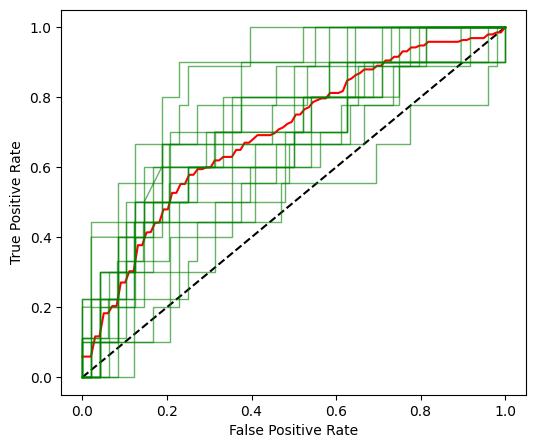

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

plt.plot([0,1],[0,1],'--',color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

mean_tpr = np.mean(tprs_ls, axis=0)
plt.plot(mean_fpr, mean_tpr, color='red')

for i,j in zip(curve_fprs, curve_tprs):
    plt.plot(i, j, color='green', linewidth=1, alpha=0.6, label=None)

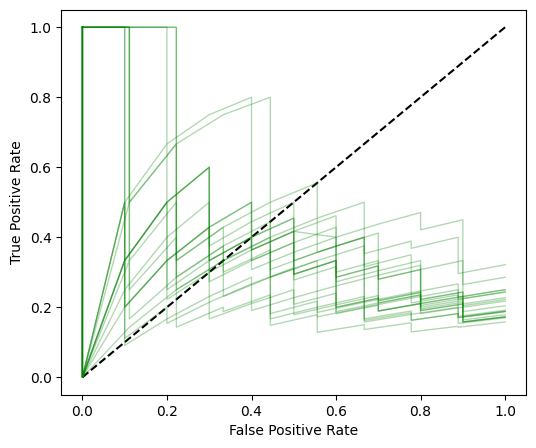

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

plt.plot([0,1],[0,1],'--',color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for i,j in zip(curve_rec, curve_pre):
    plt.plot(i, j, color='green', linewidth=1, alpha=0.3, label=None)

# 1010

In [27]:
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE
seed = 7
skfold = RepeatedStratifiedKFold(n_splits=10,random_state=seed,n_repeats=10)

proba_score = []
predict_score = []
acc_score = []
re_score = []
prauc_score = []
specifi_score = []
cm1_score = []

curve_fprs = []
curve_tprs = []
curve_thresholds = []

curve_pre = []
curve_rec = []
curve_thr = []

tprs_ls = []
mean_fpr = np.linspace(0,1,100)

x_df = merge_df.drop(['Key','cutoff'],axis=1)
y_df = merge_df['cutoff']

sc = StandardScaler()
x_df = pd.DataFrame(sc.fit_transform(x_df), columns=x_df.columns)

for j, (train_idx, val_idx) in enumerate(skfold.split(x_df,y_df)):

    x_train, y_train = x_df.iloc[train_idx], y_df.iloc[train_idx]
    x_test, y_test = x_df.iloc[val_idx], y_df.iloc[val_idx]

    x_train_sk, x_val_sk, y_train_sk, y_val_sk = train_test_split(x_train,y_train,stratify=y_train, random_state=seed, test_size=0.2)

    #SMOTE로 타겟의 분포를 균등하게 조절
    smote = SMOTE(random_state=42)
    x_train_sk, y_train_sk = smote.fit_resample(x_train_sk, y_train_sk)
    print(' 변화된 값의 분포 :\n',pd.Series(y_train_sk).value_counts() )
    
    
    model = catboost.CatBoostClassifier(
                                    use_best_model=True,
                                    eval_metric='AUC',
                                    verbose=False,
                                    random_state=seed
                                    )
    D_train = catboost.Pool(x_train_sk, y_train_sk)
    D_test = catboost.Pool(x_val_sk, y_val_sk)

    model.fit(D_train, eval_set=D_test, verbose=False)

    pred = model.predict_proba(x_test)[:,1]
    fprs, tprs, thresholds = roc_curve(y_test, pred)

    tprs_ls.append(np.interp(mean_fpr, fprs, tprs))

    curve_tprs.append(tprs)
    curve_fprs.append(fprs)
    curve_thresholds.append(thresholds)

    J = tprs - fprs
    ix = np.argmax(J)
    best_thresh = thresholds[ix]

    precision, recall, th = precision_recall_curve(y_test, pred)
    prauc = auc(recall, precision)

    curve_pre.append(precision)
    curve_rec.append(recall)
    curve_thr.append(th)
        
    cm1 = confusion_matrix(y_test, np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0))

    Specificity = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    Sensitivity = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    print(j,'번째')
    print('Youden index threshold : ',best_thresh)

    print('roc_auc_score : ',roc_auc_score(y_test,model.predict_proba(x_test)[:,1]))
    print('acc : ',accuracy_score(y_test,np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0)))
    print('sensitivity : ',Sensitivity)
    print('specificity : ',Specificity)
    print('pr_auc : ',prauc,'\n')
    print(cm1)

    proba_score.append(roc_auc_score(y_test,model.predict_proba(x_test)[:,1]))
    acc_score.append(accuracy_score(y_test,np.where(model.predict_proba(x_test)[:,1] >= best_thresh , 1, 0)))
    re_score.append(Sensitivity)
    specifi_score.append(Specificity)
    prauc_score.append(prauc)
    cm1_score.append(cm1)

 변화된 값의 분포 :
 0    174
1    174
Name: cutoff, dtype: int64
0 번째
Youden index threshold :  0.4992285950524895
roc_auc_score :  0.6708333333333334
acc :  0.7241379310344828
sensitivity :  0.8
specificity :  0.7083333333333334
pr_auc :  0.28729549186445735 

[[17  7]
 [ 1  4]]
 변화된 값의 분포 :
 0    174
1    174
Name: cutoff, dtype: int64
1 번째
Youden index threshold :  0.24880986128353888
roc_auc_score :  0.8500000000000001
acc :  0.8275862068965517
sensitivity :  0.8
specificity :  0.8333333333333334
pr_auc :  0.6407738095238096 

[[20  4]
 [ 1  4]]
 변화된 값의 분포 :
 0    174
1    174
Name: cutoff, dtype: int64
2 번째
Youden index threshold :  0.4078397677380882
roc_auc_score :  0.9416666666666667
acc :  0.9310344827586207
sensitivity :  1.0
specificity :  0.9166666666666666
pr_auc :  0.6914285714285714 

[[22  2]
 [ 0  5]]
 변화된 값의 분포 :
 0    174
1    174
Name: cutoff, dtype: int64
3 번째
Youden index threshold :  0.37200010067611616
roc_auc_score :  0.8166666666666667
acc :  0.7931034482758621
sens

In [28]:
print('proba_score',np.mean(proba_score))
print('re_score',np.mean(re_score))
print('specifi_score',np.mean(specifi_score))
proba_score

proba_score 0.7022333333333333
re_score 0.773
specifi_score 0.7245333333333334


[0.6708333333333334,
 0.8500000000000001,
 0.9416666666666667,
 0.8166666666666667,
 0.8500000000000001,
 0.5833333333333333,
 0.7333333333333334,
 0.6250000000000001,
 0.74,
 0.5520833333333333,
 0.5416666666666666,
 0.7833333333333333,
 0.7833333333333333,
 0.7583333333333334,
 0.8333333333333333,
 0.5916666666666667,
 0.725,
 0.8500000000000001,
 0.71,
 0.8541666666666667,
 0.5583333333333333,
 0.7666666666666666,
 0.7583333333333333,
 0.6000000000000001,
 0.5083333333333333,
 0.8416666666666666,
 0.8500000000000001,
 0.6833333333333333,
 0.51,
 0.8437499999999999,
 0.9083333333333333,
 0.55,
 0.4083333333333333,
 0.8666666666666667,
 0.7666666666666667,
 0.6333333333333333,
 0.6416666666666666,
 0.6,
 0.9199999999999999,
 0.6354166666666666,
 0.6833333333333333,
 0.6833333333333333,
 0.75,
 0.775,
 0.6583333333333333,
 0.8833333333333334,
 0.5166666666666666,
 0.8166666666666667,
 0.8200000000000001,
 0.5520833333333334,
 0.6833333333333333,
 0.4833333333333333,
 0.6916666666666667

In [29]:
TN_ls = []
FP_ls = []
FN_ls = []
TP_ls = []

for i in range(20):
    TN_ls.append(cm1_score[i][0][0]) # TN
    FP_ls.append(cm1_score[i][0][1]) # FP
    FN_ls.append(cm1_score[i][1][0]) # FN
    TP_ls.append(cm1_score[i][1][1]) # TP

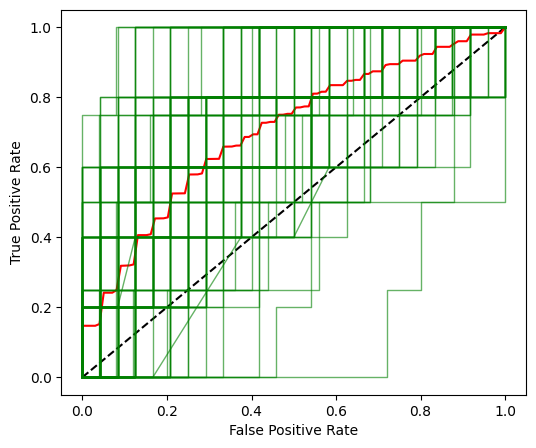

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

plt.plot([0,1],[0,1],'--',color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

mean_tpr = np.mean(tprs_ls, axis=0)
plt.plot(mean_fpr, mean_tpr, color='red')

for i,j in zip(curve_fprs, curve_tprs):
    plt.plot(i, j, color='green', linewidth=1, alpha=0.6, label=None)

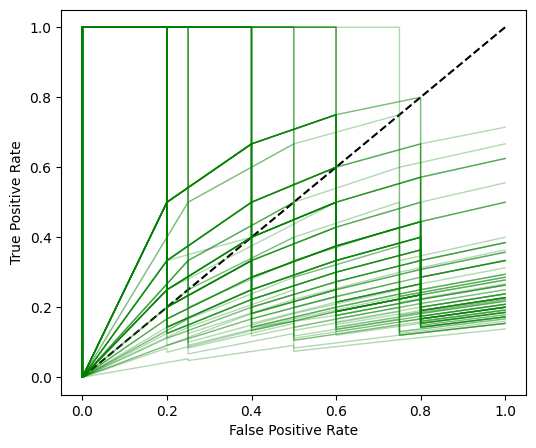

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

plt.plot([0,1],[0,1],'--',color='black')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

for i,j in zip(curve_rec, curve_pre):
    plt.plot(i, j, color='green', linewidth=1, alpha=0.3, label=None)

In [ ]:
CF_item = pd.DataFrame()
CF_item['proba_score'] = proba_score
CF_item['re_score'] = re_score
CF_item['specifi_score'] = specifi_score 
CF_item.to_csv('RF_model_1010.csv',index=False)